# Подключение библиотеки

In [1]:
import os
import pathlib
from datasets import load_dataset, load_from_disk

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-02-27 14:26:03.577982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 14:26:03.578021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 14:26:03.578834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 14:26:03.584201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 14:26:04.265331: W tensorflow/compiler/tf2

## Загрузка датасет

In [2]:
data_dir = '/home/redalexdad/recognition_speech/buriy_audiobooks_2_val'
data_dir

'/home/redalexdad/recognition_speech/buriy_audiobooks_2_val'

In [3]:
# Создаем датасет
ds = tf.keras.utils.audio_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',  # используем целые числа для меток
    batch_size=64,
    validation_split=0.2,
    subset='training',
    seed=1337,
    output_sequence_length=16000,
    shuffle=True,
    follow_links=False,
)

Found 7850 files belonging to 16 classes.
Using 6280 files for training.


2024-02-27 14:26:05.590263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 14:26:05.621978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 14:26:05.625303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Содержимое датасет

In [4]:
# Печатаем информацию о датасете
ds.element_spec
print("Number of classes:", len(ds.class_names))
print("Class names:", ds.class_names)

Number of classes: 16
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f']


In [5]:
label_names = []

# Цикл по каталогами
for class_name in ds.class_names[:2]:
    
    # Цикл по батчам
    for batch in ds:
        
        # Получаем аудио и метки
        audio, labels = batch
        
        # Проходим по каждой метке в батче
        for label in labels:
            
            # Получаем каталог для метки
            label_dir = os.path.join(data_dir, f"{class_name}/{label:02x}")
            
            # Проверяем существование каталога
            if not os.path.exists(label_dir):
                print(f"Directory not found: {label_dir}")
                continue
                
            # Получаем список файлов в каталоге
            files = os.listdir(label_dir)
            
            # Проверяем, что есть файлы в каталоге
            if not files:
                print(f"No files found in directory: {label_dir}")
                continue
                
            # Выбираем первый файл, который является текстовым файлом
            text_file = next((file for file in files if file.endswith(".txt")), None)
            
            # Проверяем, что найден текстовый файл
            if text_file is None:
                print(f"No text files found in directory: {label_dir}")
                continue
                
            # Формируем путь к текстовому файлу
            text_file_path = os.path.join(label_dir, text_file)
            # Читаем текст из файла
            with open(text_file_path, "r", encoding="utf-8") as file:
                text = file.read()
                
                # Сохраним тексты для составления сонограммы
                label_names.append(text)
            print(f"Label {label}: {text}")

Label 1: фоне пылавшего

Label 15: ещё долго плавали

Label 1: фоне пылавшего

Label 3: хотел попросить

Label 0: прыгай

Label 3: хотел попросить

Label 3: хотел попросить

Label 14: влазьте в о зэ ка

Label 3: хотел попросить

Label 3: хотел попросить

Directory not found: /home/redalexdad/recognition_speech/buriy_audiobooks_2_val/0/08
Directory not found: /home/redalexdad/recognition_speech/buriy_audiobooks_2_val/0/08
Label 13: открыли торгсины где только за золото продавались хорошие товары

Label 15: ещё долго плавали

Label 6: временем этакое ощущение разумной самодостаточности

Label 9: при землетрясении

Directory not found: /home/redalexdad/recognition_speech/buriy_audiobooks_2_val/0/04
Label 13: открыли торгсины где только за золото продавались хорошие товары

Label 0: прыгай

Label 1: фоне пылавшего

Directory not found: /home/redalexdad/recognition_speech/buriy_audiobooks_2_val/0/08
Label 2: толстый вельможа

Label 14: влазьте в о зэ ка

Label 3: хотел попросить

Label 15: 

In [6]:
# Выводим первый батч данных
for batch in ds.take(1):
    audio, label = batch
    print("Audio shape:", audio.shape)
    print("Label shape:", label.shape)

Audio shape: (64, 16000, 1)
Label shape: (64,)


In [7]:
ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

ds = ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
for example_audio, example_labels in ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


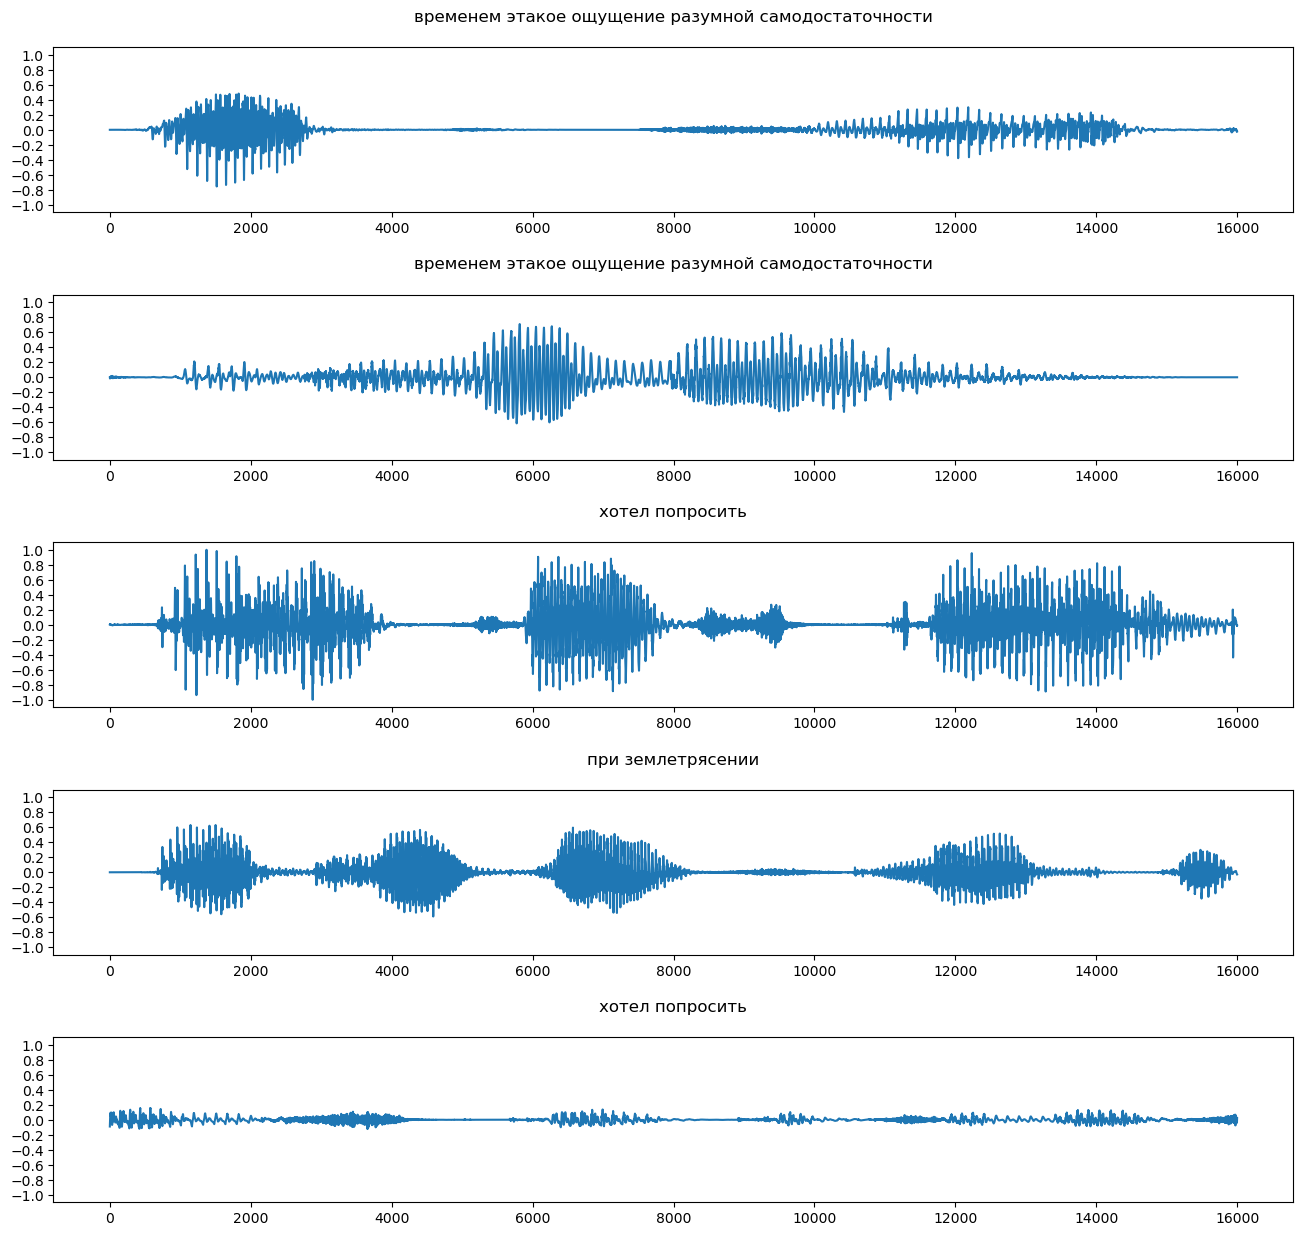

In [10]:
plt.figure(figsize=(16, 15))

rows = 5
cols = 1
n = rows * cols

# Расстояние между подграфиками по вертикали
plt.subplots_adjust(hspace=0.5)

for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Преобразование сигналов в спектрограммы

In [11]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [12]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: временем этакое ощущение разумной самодостаточности

Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: временем этакое ощущение разумной самодостаточности

Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: хотел попросить

Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [14]:
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: хотел попросить

Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


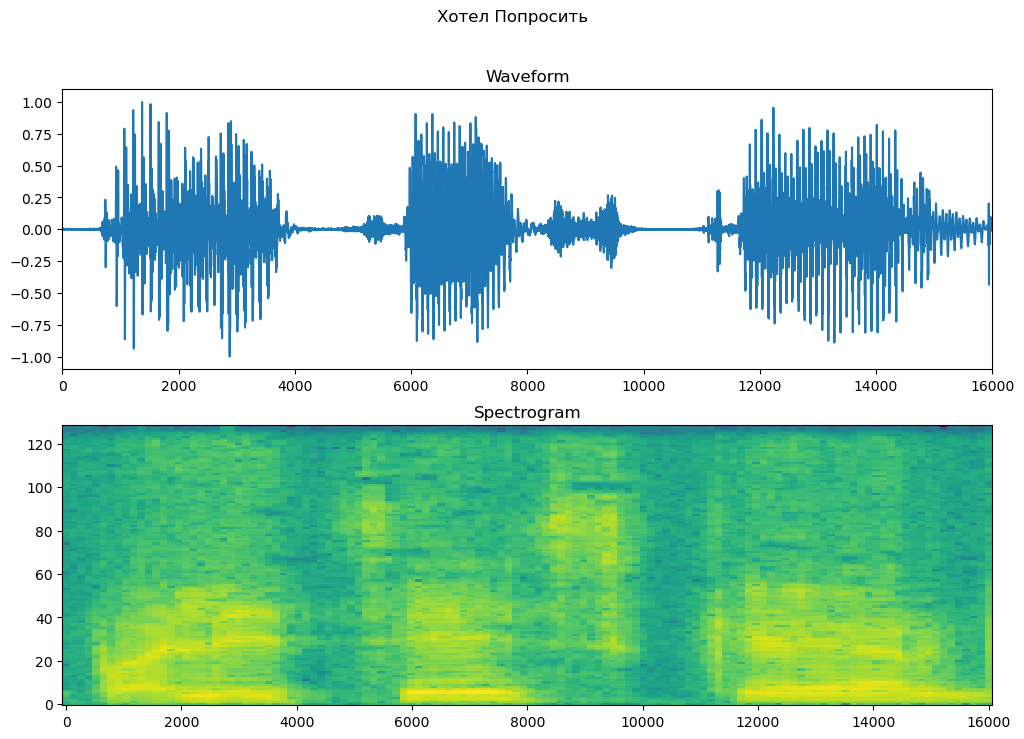

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Обучение модели

In [22]:
# Разделение на обучающую, валидационную и тестовую выборки
train_size = int(0.6 * len(ds))
val_size = int(0.2 * len(ds))
test_size = len(ds) - train_size - val_size

In [23]:
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

In [30]:
# Пример кэширования, перемешивания и предварительной выборки
train_spectrogram_ds = train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (16000,)


In [32]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

ValueError: Exception encountered when calling layer "resizing_1" (type Resizing).

'images' must have either 3 or 4 dimensions.

Call arguments received by layer "resizing_1" (type Resizing):
  • inputs=tf.Tensor(shape=(None, 16000), dtype=float32)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [11]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Количество классов, равное числу уникальных символов в текстах: 99


In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')